In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.linear_model import Ridge

from scipy.stats import special_ortho_group

import gzip
import pickle

plt.rcParams.update({'font.size': 16})

# local modules
import ridge_dgps
import ridge_theory
import hyperparam

# Simulation Study. This code produces Table 1.

In [3]:
np.random.seed(30)

n = 2000
d = 50

# Mean Shift Experiments

In [4]:
class HyperparamExperiment:

    def __init__(self, n, d, problem_features):
        # usual is not curved and min_eig=1e-6, max_eig=2
        beta_zero, sigma_hat, train_cov, X = problem_features
        self.ridge = ridge_theory.RidgeAnalysis(beta_zero, sigma_hat, train_cov, X)

        self.n = n
        self.d = d

        self.iid_opt_lambdas = []
        self.iid_opt_mses = []
        self.all_tunings = []
        self.all_errors = []

    def draw_y(self):
        y = np.random.normal(loc=self.ridge.X@self.ridge.beta_zero , scale=np.sqrt(self.sigma2_y))
        return y

    def calc_opt_iid_lambda(self):
        iid_obj = self.ridge.gen_iid_objective(self.sigma2_y)
        iid_opt_lambda, iid_opt_mse = self.ridge.solve_optimization(iid_obj)
        self.iid_opt_lambdas.append(iid_opt_lambda)
        self.iid_opt_mses.append(iid_opt_mse)
        return iid_opt_lambda, iid_opt_mse

    def calc_plug_in_delta(self, y, test_mean_outer, obj_scale):
        cv_lam = hyperparam.cross_val_ridge_solver(y, self.ridge.X, repeats=5)

        reg_inv_cov = self.ridge.evecs @ np.diag( 1/(self.ridge.evals+cv_lam) ) @ self.ridge.evecs.T
        beta_hat = reg_inv_cov @ self.ridge.X.T @ y/n

        plugin_ridge = ridge_theory.RidgeAnalysis(beta_hat, self.ridge.sigma_hat, self.ridge.sigma_hat, self.ridge.X)
        plugin_sigma2 = (self.ridge.X@beta_hat - y).std()**2
        mean_obj = plugin_ridge.gen_mean_objective(test_mean_outer, plugin_sigma2, cv_lam, obj_scale)
        plug_delta, plug_mse = plugin_ridge.solve_optimization(mean_obj)

        max_delta = 100000
        max_val = mean_obj(max_delta)
        if max_val <= plug_mse:
            plug_delta = max_delta

        return cv_lam, plug_delta
    
    def calc_opt_delta(self, iid_opt_lambda, test_mean_outer, obj_scale):
        mean_obj = self.ridge.gen_mean_objective(test_mean_outer, self.sigma2_y, iid_opt_lambda, obj_scale)
        mean_opt_delta, mean_opt_mse = self.ridge.solve_optimization(mean_obj)

        max_delta = 100000
        max_val = mean_obj(max_delta)
        if max_val <= mean_opt_mse:
            mean_opt_delta = max_delta
            mean_opt_mse = max_val

        return mean_opt_delta, mean_opt_mse
    
    def run_experiment(self, targets, sigma2_ys):
        self.targets = targets 
        self.sigma2_ys = sigma2_ys

        self.iid_opt_lambdas = []
        self.iid_opt_mses = []
        self.all_tunings = []
        self.all_errors = []

        for sig in sigma2_ys:

            self.sigma2_y = sig
            iid_opt_lambda, _ = self.calc_opt_iid_lambda()

            mean_opt_deltas = []
            cv_bal_deltas = []
            cv_auto_deltas = []
            sig_over_n_deltas = []
            lam_eq_deltas = []

            mean_opt_mses = []
            cv_bal_mses = []
            cv_auto_mses = []
            sig_over_n_mses = []
            lam_eq_mses = []

            for test_mean_outer, test_mean in targets:

                obj_scale = (np.linalg.norm(test_mean))**2
                mean_opt_delta, mean_opt_mse = self.calc_opt_delta(iid_opt_lambda, test_mean_outer, obj_scale)

                mse_function = self.ridge.gen_mean_objective(test_mean_outer, self.sigma2_y, iid_opt_lambda, obj_scale)
                # opt_gamma = self.ridge.calc_gamma(iid_opt_lambda, mean_opt_delta) 

                cv_bal_del = np.quantile(hyperparam.cross_val_bal_solver(test_mean, self.ridge.X, ks=5), 0.5)
                cv_auto_del = np.quantile(hyperparam.cross_val_autodml_solver(test_mean, self.ridge.X, ks=5),0.5)
                sig_over_n_del = self.sigma2_y / (n*n)
                lam_eq_del = iid_opt_lambda

                cv_bal_mse = mse_function(cv_bal_del) * obj_scale
                cv_auto_mse = mse_function(cv_auto_del) * obj_scale
                sig_over_n_mse = mse_function(sig_over_n_del) * obj_scale
                lam_eq_mse = mse_function(lam_eq_del) * obj_scale

                mean_opt_deltas.append( mean_opt_delta )
                cv_bal_deltas.append( cv_bal_del )
                cv_auto_deltas.append( cv_auto_del )
                sig_over_n_deltas.append(sig_over_n_del)
                lam_eq_deltas.append( lam_eq_del )

                mean_opt_mses.append(mean_opt_mse*obj_scale)
                cv_bal_mses.append(cv_bal_mse)
                cv_auto_mses.append(cv_auto_mse)
                sig_over_n_mses.append(sig_over_n_mse)
                lam_eq_mses.append(lam_eq_mse)
            
            self.all_tunings.append([mean_opt_deltas, cv_bal_deltas, cv_auto_deltas, sig_over_n_deltas, lam_eq_deltas])
            self.all_errors.append([mean_opt_mses, cv_bal_mses, cv_auto_mses, sig_over_n_mses, lam_eq_mses])

    def run_montecarlo_experiment(self, targets, sigma2_ys, nrepeats):
        self.targets = targets 
        self.sigma2_ys = sigma2_ys

        self.iid_opt_lambdas = []
        self.iid_opt_mses = []
        self.all_tunings = []
        self.all_errors = []

        for sig in sigma2_ys:

            self.sigma2_y = sig
            iid_opt_lambda, _ = self.calc_opt_iid_lambda()

            mean_opt_deltas = []
            cv_bal_deltas = []
            cv_auto_deltas = []
            #sig_over_n_deltas = []
            lam_eq_deltas = []

            mean_opt_mses = []
            cv_bal_mses = []
            cv_auto_mses = []
            #sig_over_n_mses = []
            lam_eq_mses = []

            for test_mean_outer, test_mean in targets:

                obj_scale = (np.linalg.norm(test_mean))**2
                mean_opt_delta, mean_opt_mse = self.calc_opt_delta(iid_opt_lambda, test_mean_outer, obj_scale)

                # mse_function = self.ridge.gen_mean_objective(test_mean_outer, self.sigma2_y, iid_opt_lambda, obj_scale)
                # opt_gamma = self.ridge.calc_gamma(iid_opt_lambda, mean_opt_delta) 

                cv_bal_del = np.quantile(hyperparam.cross_val_bal_solver(test_mean, self.ridge.X, ks=5), 0.5)
                cv_auto_del = np.quantile(hyperparam.cross_val_autodml_solver(test_mean, self.ridge.X, ks=5), 0.5)
                # sig_over_n_del = self.sigma2_y / (n*n)
                
                avg_del_eq_lam = 0
                avg_opt_mse = 0
                avg_bal_mse = 0
                avg_auto_mse = 0
                # avg_sig_mse = 0
                avg_lam_mse = 0
                for _ in range(nrepeats):
                    y = self.draw_y()

                    ridge_cv_lam = hyperparam.cross_val_ridge_solver(y, self.ridge.X, repeats=1)
                    avg_del_eq_lam += ridge_cv_lam/nrepeats
                    
                    avg_opt_mse += self.ridge.calc_mc_sq_err(y, iid_opt_lambda, mean_opt_delta, test_mean)/nrepeats
                    avg_bal_mse += self.ridge.calc_mc_sq_err(y, ridge_cv_lam, cv_bal_del, test_mean)/nrepeats
                    avg_auto_mse += self.ridge.calc_mc_sq_err(y, ridge_cv_lam, cv_auto_del, test_mean)/nrepeats
                    # avg_sig_mse += self.ridge.calc_mc_sq_err(y, ridge_cv_lam, sig_over_n_del, test_mean)/nrepeats
                    avg_lam_mse += self.ridge.calc_mc_sq_err(y, ridge_cv_lam, ridge_cv_lam, test_mean)/nrepeats                   

                mean_opt_deltas.append( mean_opt_delta )
                cv_bal_deltas.append( cv_bal_del )
                cv_auto_deltas.append( cv_auto_del )
                # sig_over_n_deltas.append(avg_sig_mse)
                lam_eq_deltas.append( avg_del_eq_lam )

                mean_opt_mses.append(avg_opt_mse)
                cv_bal_mses.append(avg_bal_mse)
                cv_auto_mses.append(avg_auto_mse)
                # sig_over_n_mses.append(avg_sig_mse)
                lam_eq_mses.append(avg_lam_mse)
            
            self.all_tunings.append([mean_opt_deltas, cv_bal_deltas, cv_auto_deltas, lam_eq_deltas])
            self.all_errors.append([mean_opt_mses, cv_bal_mses, cv_auto_mses, lam_eq_mses])

    def print_tunings(self):
        measure_names = ["mean_opt_deltas", "cv_bal_deltas", "cv_auto_deltas", "sig_over_n_deltas", "lam_eq_deltas"]

        target_norms = [np.linalg.norm(test_mean) for (test_mean_outer, test_mean) in self.targets]

        for i in range(len(measure_names)):
            print(measure_names[i])
            data = np.array(self.all_tunings)[:, i, :]
            print(data)

            plt.figure()
            for dat in data:
                plt.plot(target_norms, dat)
            plt.grid()
            plt.ylim([0, 0.2])
            plt.figure()
            for dat in data.T:
                plt.plot(self.sigma2_ys, dat)
            plt.grid()
            plt.ylim([0, 0.2])

            plt.show()

    def print_errors(self):
        measure_names = ["mean_opt_mses", "cv_bal_mses", "cv_auto_mses", "sig_over_n_mses", "lam_eq_mses"]

        target_norms = [np.linalg.norm(test_mean) for test_mean_outer, test_mean in self.targets]

        for i in range(len(measure_names)):
            print(measure_names[i])
            data = np.array(self.all_errors)[:, i, :]
            print(data)

            plt.figure()
            for dat in data:
                plt.plot(target_norms, dat)
            plt.grid()
            #plt.ylim([0, 0.2])
            plt.figure()
            for dat in data.T:
                plt.plot(self.sigma2_ys, dat)
            plt.grid()
            #plt.ylim([0, 0.2])

            plt.show()

    def save(self, filename):
        with gzip.open(filename, 'wb') as f:
            pickle.dump(self, f)        
            
def load_experiment(filename):
    with gzip.open(filename, 'rb') as f:
        experiment = pickle.load(f)    
    return experiment


In [5]:
nTrials = 1000

In [6]:
np.random.seed(5)

n = 2000
d = 50
mean_scalers = [0.1, 2]
sigma2_ys = [0.1, 2]
beta_zero, train_cov = ridge_dgps.setup_curved_source_dgp(scaler=1, min_eig=1e-4, max_eig=3, n=n, d=d)
X, sigma_hat = ridge_dgps.draw_X(train_cov, n)

rands = []
for _ in range(3):
    arr = np.random.uniform(-1,1, size=d)
    arr /= np.linalg.norm(arr)
    # arr *= np.linalg.norm(1)
    rands.append(arr)

problem_features = beta_zero, sigma_hat, train_cov, X
targets = [ridge_dgps.mean_shift_tests(d, scaler=mean_scaler) for mean_scaler in mean_scalers] + [ (np.outer(test_mean,test_mean) , test_mean) for test_mean in rands ] 

experiment1 = HyperparamExperiment(n, d, problem_features)
experiment1.run_montecarlo_experiment(targets, sigma2_ys, nTrials)

In [7]:
# ["mean_opt_deltas", "cv_bal_deltas", "cv_auto_deltas", "sig_over_n_deltas", "lam_eq_deltas"]
tunings1 = experiment1.all_tunings

In [8]:
optimal_err1  = np.array(experiment1.all_errors)[:, 0, :][:, np.newaxis, :]
relative_err1 = (np.array(experiment1.all_errors) - optimal_err1) / optimal_err1

In [9]:
np.random.seed(5)

n = 2000
d = 50
mean_scalers = [0.1, 2]
sigma2_ys = [0.1, 2]
beta_zero, train_cov = ridge_dgps.setup_curved_source_dgp(scaler=1, min_eig=1e-10, max_eig=5, curve=10, n=n, d=d)
X, sigma_hat = ridge_dgps.draw_X(train_cov, n)

rands = []
for _ in range(3):
    arr = np.random.uniform(-1,1, size=d)
    arr /= np.linalg.norm(arr)
    # arr *= np.linalg.norm(1)
    rands.append(arr)

problem_features = beta_zero, sigma_hat, train_cov, X
targets = [ridge_dgps.mean_shift_tests(d, scaler=mean_scaler) for mean_scaler in mean_scalers] + [ (np.outer(test_mean,test_mean) , test_mean) for test_mean in rands ] 

experiment2 = HyperparamExperiment(n, d, problem_features)
#experiment2.run_experiment(targets, sigma2_ys)

experiment2.run_montecarlo_experiment(targets, sigma2_ys, nTrials)

In [10]:
# ["mean_opt_deltas", "cv_bal_deltas", "cv_auto_deltas", "sig_over_n_deltas", "lam_eq_deltas"]
tunings2 = experiment2.all_tunings

In [11]:
tunings2

[[[0.000242050781703167,
   0.0002420507824247639,
   0.0032375406967808077,
   0.007568521685692747,
   0.0016842986841533528],
  [0.042920056733706684,
   0.07423766818912261,
   0.04341287513728593,
   0.05217889271522427,
   0.028909459884665836],
  [0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0028942395393227465,
   0.002912667326077317,
   0.0029327760780586396,
   0.002936364180008464,
   0.002961123923850357]],
 [[0.001824639805802119,
   0.0018246398644418133,
   0.017731560138735825,
   100000,
   0.006753097003953058],
  [0.03682155732074355,
   0.054055414191055785,
   0.08857863099150264,
   0.043277714691099894,
   0.06692069682833778],
  [0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0713453971316206,
   0.07150771442875695,
   0.0705591137033944,
   0.06962523042170853,
   0.07158224776790614]]]

In [12]:
optimal_err2  = np.array(experiment2.all_errors)[:, 0, :][:, np.newaxis, :]
relative_err2 = (np.array(experiment2.all_errors) - optimal_err2) / optimal_err2
["mean_opt_mses", "cv_bal_mses", "cv_auto_mses", "sig_over_n_mses", "lam_eq_mses"]
relative_err2

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [3.74145781e+03, 9.16861796e+02, 1.62584616e+05, 5.58840948e+04,
         2.33959851e+03],
        [6.83607132e+04, 5.88434014e+04, 7.75905113e+06, 2.04764810e+06,
         5.36165894e+05],
        [3.74114299e+03, 9.16558081e+02, 1.62584750e+05, 5.58928299e+04,
         2.79629982e+03]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [4.46252441e-01, 5.76819494e-01, 1.37214331e-01, 9.11894499e+04,
         3.60155690e-01],
        [5.96674895e+05, 6.13283956e+05, 2.96719887e+07, 1.90918085e+07,
         3.80166027e+06],
        [5.53386700e-01, 6.12934459e-01, 1.79535984e-01, 9.11896947e+04,
         3.75595699e-01]]])

In [13]:
np.random.seed(5)

n = 2000
d = 50
mean_scalers = [0.1, 2]
sigma2_ys = [0.1, 2]
beta_zero, train_cov = ridge_dgps.setup_curved_source_dgp(scaler=1, min_eig=1e-8, max_eig=3, curve=5000, n=n, d=d)
X, sigma_hat = ridge_dgps.draw_X(train_cov, n)

rands = []
for _ in range(3):
    arr = np.random.uniform(-1,1, size=d)
    arr /= np.linalg.norm(arr)
    # arr *= np.linalg.norm(1)
    rands.append(arr)

problem_features = beta_zero, sigma_hat, train_cov, X
targets = [ridge_dgps.mean_shift_tests(d, scaler=mean_scaler) for mean_scaler in mean_scalers] + [ (np.outer(test_mean,test_mean) , test_mean) for test_mean in rands ] 

experiment3 = HyperparamExperiment(n, d, problem_features)
#experiment3.run_experiment(targets, sigma2_ys)

experiment3.run_montecarlo_experiment(targets, sigma2_ys, nTrials)


# X, sigma_hat = ridge_dgps.draw_X(train_cov, n)
# problem_features = beta_zero, sigma_hat, train_cov, X
# experiment1_2 = HyperparamExperiment(n, d, problem_features)
# experiment1_2.run_experiment(targets, sigma2_ys)

In [14]:
optimal_err3  = np.array(experiment3.all_errors)[:, 0, :][:, np.newaxis, :]
relative_err3 = (np.array(experiment3.all_errors) - optimal_err3) / optimal_err3
["mean_opt_mses", "cv_bal_mses", "cv_auto_mses", "sig_over_n_mses", "lam_eq_mses"]
relative_err3

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [6.11333058e-01, 6.94272742e-01, 5.13669075e-01, 1.81791333e-01,
         3.19838959e-01],
        [8.90738889e+02, 8.36242831e+02, 2.65058565e+04, 2.22660298e+04,
         6.09343342e+03],
        [5.45122083e-01, 5.52621961e-01, 1.46892844e+00, 3.58951651e-01,
         2.86051017e-01]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [1.88049318e-01, 1.49966559e-01, 4.82475395e-01, 3.03136779e+00,
         2.65864517e-01],
        [1.09186160e+04, 1.02887936e+04, 5.89198977e+05, 1.34229742e+06,
         9.20204027e+04],
        [2.55787503e-01, 2.71293523e-01, 4.91722330e-01, 2.26366286e+00,
         2.25001238e-01]]])

In [15]:
# ["mean_opt_deltas", "cv_bal_deltas", "cv_auto_deltas", "sig_over_n_deltas", "lam_eq_deltas"]
tunings3 = experiment3.all_tunings

In [16]:
all_rel_err = np.concatenate([relative_err1[0], relative_err1[1], relative_err2[0], relative_err2[1], relative_err3[0], relative_err3[1]], axis=1)[1:, :]

In [17]:
all_rel_err

array([[1.24719086e+00, 1.64901875e+00, 1.68340069e-01, 9.38172711e-02,
        1.93392692e-01, 4.46055781e-01, 6.03884030e-01, 6.87675683e-02,
        3.81435842e-01, 2.00436002e-01, 3.74145781e+03, 9.16861796e+02,
        1.62584616e+05, 5.58840948e+04, 2.33959851e+03, 4.46252441e-01,
        5.76819494e-01, 1.37214331e-01, 9.11894499e+04, 3.60155690e-01,
        6.11333058e-01, 6.94272742e-01, 5.13669075e-01, 1.81791333e-01,
        3.19838959e-01, 1.88049318e-01, 1.49966559e-01, 4.82475395e-01,
        3.03136779e+00, 2.65864517e-01],
       [6.52071505e-01, 7.35631183e-01, 2.02713231e+01, 1.00953773e+01,
        5.88379387e+00, 6.78634154e+00, 7.05887780e+00, 1.03735289e+02,
        1.02282793e+02, 3.59786439e+01, 6.83607132e+04, 5.88434014e+04,
        7.75905113e+06, 2.04764810e+06, 5.36165894e+05, 5.96674895e+05,
        6.13283956e+05, 2.96719887e+07, 1.90918085e+07, 3.80166027e+06,
        8.90738889e+02, 8.36242831e+02, 2.65058565e+04, 2.22660298e+04,
        6.09343342e+03,

In [18]:
np.argmin(all_rel_err, axis=0)

array([2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 2, 0, 0, 0, 2, 2], dtype=int64)

In [19]:
np.min(all_rel_err, axis=0)

array([5.15217443e-01, 6.57626311e-01, 1.68340069e-01, 9.38172711e-02,
       1.93392692e-01, 4.46055781e-01, 6.03884030e-01, 6.87675683e-02,
       3.81435842e-01, 2.00436002e-01, 3.74114299e+03, 9.16558081e+02,
       1.62584616e+05, 5.58840948e+04, 2.33959851e+03, 4.46252441e-01,
       5.76819494e-01, 1.37214331e-01, 9.11894499e+04, 3.60155690e-01,
       5.45122083e-01, 5.52621961e-01, 5.13669075e-01, 1.81791333e-01,
       2.86051017e-01, 1.88049318e-01, 1.49966559e-01, 4.82475395e-01,
       2.26366286e+00, 2.25001238e-01])

In [20]:
np.argmax(all_rel_err, axis=0)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [21]:
np.max(all_rel_err, axis=0)

array([1.24719086e+00, 1.64901875e+00, 2.02713231e+01, 1.00953773e+01,
       5.88379387e+00, 6.78634154e+00, 7.05887780e+00, 1.03735289e+02,
       1.02282793e+02, 3.59786439e+01, 6.83607132e+04, 5.88434014e+04,
       7.75905113e+06, 2.04764810e+06, 5.36165894e+05, 5.96674895e+05,
       6.13283956e+05, 2.96719887e+07, 1.90918085e+07, 3.80166027e+06,
       8.90738889e+02, 8.36242831e+02, 2.65058565e+04, 2.22660298e+04,
       6.09343342e+03, 1.09186160e+04, 1.02887936e+04, 5.89198977e+05,
       1.34229742e+06, 9.20204027e+04])

In [22]:
# LOAD IHDP DATA
df = pd.read_pickle('./data/IHDP.zip')

Y = np.array(df["y_factual"])
T = np.array(df["treatment"])
X = np.array(df[df.columns[5:]])

from sklearn.preprocessing import PolynomialFeatures

# discrete cols= x3, x6 - x25
Xcont = X[:, :6]
Xbin = X[:, 6:]

Xbininter = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(Xbin)
checks = []
for j in range(Xbininter.shape[1]):
    check = (Xbininter[:, j] == 0).sum() == Xbininter.shape[0]
    checks.append(check)
checks = np.array(checks)
Xbininter = Xbininter[:, ~checks]

Xcontpoly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(Xcont)

Xlong = np.concatenate([Xcontpoly, Xbininter], axis=1)

Xp = Xlong[T==0]
Xq = Xlong[T==1]

yp = Y[T==0]

Xpc = Xp - Xp.mean(axis=0)
ypc = yp - yp.mean()

n = Xpc.shape[0]
d = Xpc.shape[1]

Xqc = (Xq - Xp.mean(axis=0))
# Xqb = Xqc.mean(axis=0)
Xqb = Xqc.mean(axis=0)

# SEMI SYNTHETIC SETUP FROM HERE

beta_zero = Ridge(alpha=74, fit_intercept=False).fit(Xpc,ypc).coef_ 
sigma2_y = np.std(Xpc@beta_zero - ypc)**2
train_cov = Xpc.T@Xpc/n
X, sigma_hat = ridge_dgps.draw_X(train_cov, n)

#problem_features = beta_zero, sigma_hat, train_cov, X 
problem_features = beta_zero, train_cov, train_cov, Xpc 

# scales = np.linspace(0.1, 2, 5)
# scaled_sigs = sigma2_y * scales
# sigma2_ys = np.sort(np.insert(scaled_sigs, 0, sigma2_y))

sigma2_ys = [sigma2_y]

perturb_direction = np.ones(d)
perturb_direction[::2] *= -1
perturbs = np.linspace( -np.linalg.norm(Xqb)/10, np.linalg.norm(Xqb)/10 , 3)
test_means = [Xqb + per * perturb_direction for per in perturbs]
targets = [ (np.outer(test_mean,test_mean) , test_mean) for test_mean in test_means ]

# targets = [ (np.outer(Xqb,Xqb) , Xqb) ]

experiment_ihdp = HyperparamExperiment(n, d, problem_features)
#experiment_ihdp.run_experiment(targets, sigma2_ys)

experiment_ihdp.run_montecarlo_experiment(targets, sigma2_ys, nTrials)

In [23]:
# ["mean_opt_deltas", "cv_bal_deltas", "cv_auto_deltas", "sig_over_n_deltas", "lam_eq_deltas"]
tunings_ihdp = experiment_ihdp.all_tunings

In [24]:
tunings_ihdp

[[[100000, 100000, 100000],
  [1.2552586655856257, 0.42629308041184977, 0.44160839941550256],
  [0.24840715612808806, 0.3414459904437575, 0.0797192273333508],
  [0.15040719270095554, 0.1487367161917673, 0.1482958922092591]]]

In [25]:
np.array(experiment_ihdp.all_errors)

array([[[0.00430108, 0.00106162, 0.004911  ],
        [0.0048677 , 0.00128085, 0.00711904],
        [0.00765154, 0.0013128 , 0.01634088],
        [0.01019919, 0.00147414, 0.01161696]]])

In [26]:
optimal_err_ihdp  = np.array(experiment_ihdp.all_errors)[:, 0, :][:, np.newaxis, :]
relative_err_ihdp = (np.array(experiment_ihdp.all_errors) - optimal_err_ihdp) / optimal_err_ihdp
["mean_opt_mses", "cv_bal_mses", "cv_auto_mses", "sig_over_n_mses", "lam_eq_mses"]
relative_err_ihdp

array([[[0.        , 0.        , 0.        ],
        [0.13173796, 0.20651026, 0.44961342],
        [0.77897899, 0.23660305, 2.32740589],
        [1.371308  , 0.38858155, 1.36549966]]])

In [27]:
X = pd.read_csv('./data/nsw_psid_X.csv', index_col=0)
T = pd.read_csv('./data/nsw_psid_T.csv', index_col=0)
Y = pd.read_csv('./data/nsw_psid_Y.csv', index_col=0)
Y = np.array(Y).reshape(-1)
T = np.array(T).reshape(-1)
X = np.array(X)
Xp = X[T==0]
Xq = X[T==1]

yp = Y[T==0]

Xpc = Xp - Xp.mean(axis=0)
ypc = yp - yp.mean()

n = Xpc.shape[0]
d = Xpc.shape[1]

Xqc = (Xq - Xp.mean(axis=0))
Xqb = Xqc.mean(axis=0)

# SEMI SYNTHETIC SETUP FROM HERE

beta_zero = Ridge(alpha=144, fit_intercept=False).fit(Xpc,ypc).coef_ 
sigma2_y = np.var(Xpc@beta_zero - ypc)

train_cov = Xpc.T@Xpc/n
X, sigma_hat = ridge_dgps.draw_X(train_cov, n)

problem_features = beta_zero, sigma_hat, train_cov, X 
#problem_features = beta_zero, train_cov, train_cov, Xpc

# scales = np.linspace(0.1, 2, 5)
# scaled_sigs = sigma2_y * scales
# sigma2_ys = np.sort(np.insert(scaled_sigs, 0, sigma2_y))

sigma2_ys = [sigma2_y]

perturb_direction = np.ones(d)
perturb_direction[::2] *= -1
perturbs = np.linspace( -np.linalg.norm(Xqb)/100, np.linalg.norm(Xqb)/100 , 3)
test_means = [Xqb + per * perturb_direction for per in perturbs]
targets = [ (np.outer(test_mean,test_mean) , test_mean) for test_mean in test_means ]

# targets = [ (np.outer(Xqb,Xqb) , Xqb) ]

experiment_lalonde = HyperparamExperiment(n, d, problem_features)
experiment_lalonde.run_montecarlo_experiment(targets, sigma2_ys, nTrials)

In [28]:
# ["mean_opt_deltas", "cv_bal_deltas", "cv_auto_deltas", "sig_over_n_deltas", "lam_eq_deltas"]
tunings_lalonde = experiment_lalonde.all_tunings

In [29]:
tunings_lalonde

[[[81.58003492815031, 8.10295215776668, 3.2286607983733164],
  [0.8281163039568893, 0.8299098587969663, 0.8779017793341478],
  [1.0206617782936416e-12, 0.06515688054134018, 1.262025366099811e-12],
  [0.1883633050830882, 0.19033451339344898, 0.1881948141697467]]]

In [30]:
optimal_err_lalonde  = np.array(experiment_lalonde.all_errors)[:, 0, :][:, np.newaxis, :]
relative_err_lalonde = (np.array(experiment_lalonde.all_errors) - optimal_err_lalonde) / optimal_err_lalonde
["mean_opt_mses", "cv_bal_mses", "cv_auto_mses", "sig_over_n_mses", "lam_eq_mses"]
relative_err_lalonde

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.09604926e-01, 3.36200059e-02, 1.24310245e-02],
        [2.46172245e+06, 2.46306270e-01, 1.58106709e+06],
        [3.38124934e-01, 1.37107336e-01, 8.35514878e-02]]])

# Generate Table 1

In [31]:
names = ["CV Balance", "CV Riesz Loss", "Ridge Lambda"]

In [32]:
all_rel_err = np.concatenate([relative_err1[0], relative_err1[1], relative_err2[0], relative_err2[1], relative_err3[0], relative_err3[1], relative_err_ihdp[0], relative_err_lalonde[0]], axis=1)[1:, :]

In [33]:
all_tunings = np.concatenate([tunings1[0], tunings1[1], tunings2[0], tunings2[1], tunings3[0], tunings3[1], tunings_ihdp[0], tunings_lalonde[0]], axis=1)[1:, :]

In [34]:
print((all_tunings == 0).sum(axis=1))
print((all_tunings <= 1e-7).sum(axis=1))
print((all_tunings <= 1e-4).sum(axis=1))
print((all_tunings <= 1e-1).sum(axis=1))

[ 0 20  0]
[ 0 22  0]
[ 0 32  0]
[30 34 30]


In [35]:
res_df = pd.DataFrame()
res_df["Argmin MSE"] = np.array([names[i] for i in np.argmin(all_rel_err, axis=0)])
res_df["Min MSE"] = np.min(all_rel_err, axis=0)
res_df["Argmax MSE"] = np.array([names[i] for i in np.argmax(all_rel_err, axis=0)])
res_df["Max MSE"] = np.max(all_rel_err, axis=0)

In [36]:
res_df["Argmin MSE"].value_counts()

CV Balance      27
Ridge Lambda     9
Name: Argmin MSE, dtype: int64

In [37]:
res_df["Argmax MSE"].value_counts()

CV Riesz Loss    32
CV Balance        2
Ridge Lambda      2
Name: Argmax MSE, dtype: int64

In [38]:
summary_df = pd.DataFrame()
summary_df["Tuning Scheme"] = names
summary_df = summary_df.set_index("Tuning Scheme")
summary_df = summary_df.merge(pd.DataFrame(res_df["Argmin MSE"].value_counts()), how="left", left_index=True, right_index=True)
summary_df = summary_df.merge(pd.DataFrame(res_df["Argmax MSE"].value_counts()), how="left", left_index=True, right_index=True)
summary_df["Median Relative MSE"] = pd.Series(np.quantile(all_rel_err, 0.5, axis=1), index=names)
summary_df["Best Relative MSE"] = pd.Series(np.quantile(all_rel_err, 0.0, axis=1), index=names)
summary_df["Worst Relative MSE"] = pd.Series(np.quantile(all_rel_err, 1.0, axis=1), index=names)
summary_df = summary_df.rename(columns={"Argmin MSE": "# Times Best" , "Argmax MSE": "# Times Worst"})
summary_df[summary_df.isna()] = 0


In [39]:
summary_df

,# Times Best,# Times Worst,Median Relative MSE,Best Relative MSE,Worst Relative MSE
Tuning Scheme,,,,,
CV Balance,27.0,2,0.413746,0.012431,1.625846e+05
CV Riesz Loss,0.0,32,10603.704803,0.236603,2.967199e+07
Ridge Lambda,9.0,2,0.530170,0.083551,1.625848e+05


In [40]:
summary_df = pd.DataFrame()
summary_df["# Times Best"] = res_df["Argmin MSE"].value_counts()
summary_df["# Times Worst"] = res_df["Argmax MSE"].value_counts()
summary_df["Median Relative MSE"] = pd.Series(np.quantile(all_rel_err, 0.5, axis=1), index=names)
summary_df["Best Relative MSE"] = pd.Series(np.quantile(all_rel_err, 0.0, axis=1), index=names)
summary_df["Worst Relative MSE"] = pd.Series(np.quantile(all_rel_err, 1.0, axis=1), index=names)

In [41]:
with pd.option_context('display.float_format', '{:.3f}'.format):
    print(summary_df)

              # Times Best  # Times Worst  Median Relative MSE  \
CV Balance              27              2                0.414   
Ridge Lambda             9              2                0.530   

              Best Relative MSE  Worst Relative MSE  
CV Balance                0.012          162584.616  
Ridge Lambda              0.084          162584.750  


# Generate Figure I.11

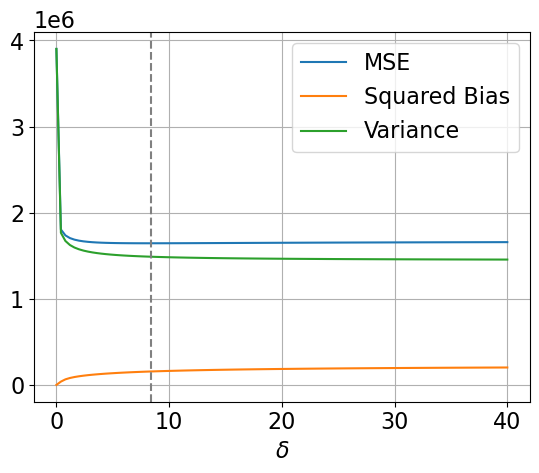

In [42]:
np.random.seed(42)

X = pd.read_csv('./data/nsw_psid_X.csv', index_col=0)
T = pd.read_csv('./data/nsw_psid_T.csv', index_col=0)
Y = pd.read_csv('./data/nsw_psid_Y.csv', index_col=0)
Y = np.array(Y).reshape(-1)
T = np.array(T).reshape(-1)
X = np.array(X)
Xp = X[T==0]
Xq = X[T==1]

yp = Y[T==0]

Xpc = Xp - Xp.mean(axis=0)
ypc = yp - yp.mean()

n = Xpc.shape[0]
d = Xpc.shape[1]

Xqc = (Xq - Xp.mean(axis=0))
Xqb = Xqc.mean(axis=0)

beta_zero = Ridge(alpha=144, fit_intercept=False).fit(Xpc,ypc).coef_ 
sigma2_y = np.var(Xpc@beta_zero - ypc)

train_cov = Xpc.T@Xpc/n
X, sigma_hat = ridge_dgps.draw_X(train_cov, n)

problem_features = beta_zero, sigma_hat, train_cov, X 
sigma2_ys = [sigma2_y]

perturb_direction = np.ones(d)
perturb_direction[::2] *= -1
perturbs = np.linspace( -np.linalg.norm(Xqb)/100, np.linalg.norm(Xqb)/100 , 3)
test_means = [Xqb + per * perturb_direction for per in perturbs]
targets = [ (np.outer(test_mean,test_mean) , test_mean) for test_mean in test_means ]

experiment_lalonde2 = HyperparamExperiment(n, d, problem_features)
experiment_lalonde2.run_experiment(targets, sigma2_ys)
test_mean_outer = np.outer(Xqb,Xqb)
experiment_lalonde2.sigma2_y = sigma2_y
iid_opt_lambda, _ = experiment_lalonde2.calc_opt_iid_lambda()
theory = experiment_lalonde2.ridge

def get_bias(delta):
    gamma = theory.calc_gamma(iid_opt_lambda, delta)
    reg_inv_cov = theory.evecs @ theory.pseudo_inv_diag(theory.evals + gamma, 1e-12) @ theory.evecs.T
    reg_mat = theory.evecs @ np.diag(gamma) @ theory.evecs.T

    return theory.general_ridge_bias( reg_mat, reg_inv_cov, test_mean_outer )

def get_variance(delta):
    gamma = theory.calc_gamma(iid_opt_lambda, delta)
    reg_inv_cov = theory.evecs @ theory.pseudo_inv_diag(theory.evals + gamma, 1e-12) @ theory.evecs.T
    reg_mat = theory.evecs @ np.diag(gamma) @ theory.evecs.T

    return theory.general_ridge_variance( reg_inv_cov, test_mean_outer, sigma2_y ) 

grid = np.linspace(0,40,101)
b2s = np.array([get_bias(delta) for delta in grid])
v2s = np.array([get_variance(delta) for delta in grid])
plt.plot(grid, v2s+b2s, label="MSE")
plt.plot(grid, b2s, label="Squared Bias")
plt.plot(grid, v2s, label="Variance")
plt.axvline(grid[np.argmin(v2s+b2s)], color='grey', linestyle='--')
plt.legend()
plt.xlabel("$\delta$")
plt.grid()

# mse = v2s+b2s
# plt.plot(grid[20:], mse[20:])
# #plt.plot(b2s[10:])
# #plt.plot(v2s[10:])
# plt.axvline(grid[np.argmin(mse)], color='grey', linestyle='--')